# Tutorial 17 - Parameter estimation and errors

Often in spectra there are what's called emission lines. A skinny excess above the surounding flux. These originate from atomic emission lines and give us valuable information about the astrophysical source. 

These lines also often have an inherent width to them, from things like originating from a hot gas or near a strong graviational pull. 

In this tutorial you will simulate an optical spectrum with a constant continum (a flat count rate across all photon energies) plus a Gaussian-like emission line centered at some photon energy and some width

In [211]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Run the next 3 cells to make the photon energies, your function to describe the emission line and to simulate your data

In [212]:
Ephotons = np.arange(1, 3, 0.01) # photon energies in eV

continuum_rate = 20.0 # the counts at each energy from the flat continuum

A_line = 15.0 # the amplitude in counts of the emission line

line_width = 0.05 # in eV, the width of the emission line

line_loc = 2.0 # in eV, the center of the emission line

In [213]:
# your function to give you the expected counts from the emission line
def emiss_line(Es, A, E0, width):
    '''
    Es: your array of photon energies (eV)
    A: the emission line amplitude (counts)
    E0: the center of your emission line (eV)
    width: the width of your emission line (eV)
    '''
    
    return A*np.exp(-((Es - E0)/(2*width))**2)

In [214]:
# this makes random generated numbers predictable 
np.random.seed(100)

Nobs = len(Ephotons) # the number of observations you have
# simulate your continum counts
counts_cont = np.random.poisson(lam=continuum_rate, size=Nobs)

# Find the expected emission line counts given the true parameters
emiss_line_avg = emiss_line(Ephotons, A_line, line_loc, line_width)

# simulate the counts from the emission line
counts_line = np.random.poisson(lam=emiss_line_avg)

# get your total counts from both 
counts = counts_cont + counts_line

Plot your counts as a function of photon Energy 

Text(0, 0.5, 'Counts')

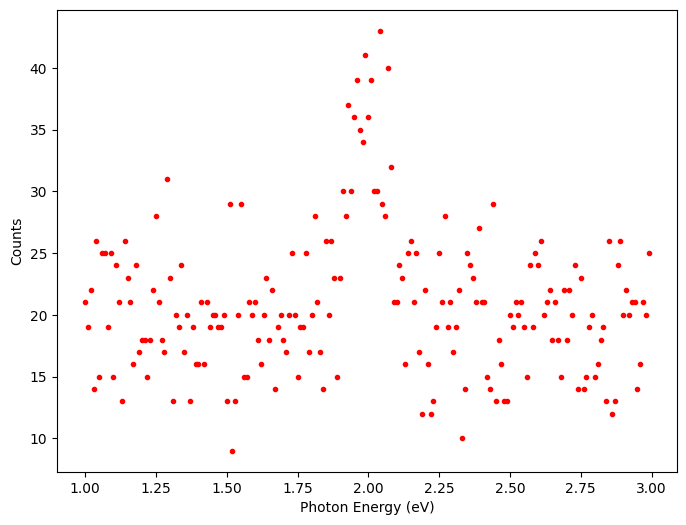

In [215]:
plt.figure(figsize=(8, 6))
plt.plot(Ephotons, counts, '.r', label='Observed Counts')
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Counts')

In [216]:
# a function to calculate the chi2 value
def calc_chi2(expected, actual, sigma):
    
    chi2 = np.sum( ((expected - actual)/sigma)**2 )
    return chi2

Thinking of Poisson count statistics, find the 1-sigma error on each observation of counts

In [217]:
sigmas = np.sqrt(counts)

Let's assume we know 
- the continuum gives an average of 20 counts 
- the amplitude of the line is 25 counts
- the width of the line is 0.05 eV

Let's find what the data can tell us about the center of the line, E0

Our model will give us our expected counts, as a function of our free parameter (E0)

counts_expected = counts_continum + counts_line

Using chi2 minimized by brute force, find the best-fit value for E0

In [218]:
#Known parameters
continuum_rate = 20
A_line = 15
line_width = 0.05

chi2s = np.zeros(len(Ephotons)) # define an array to hold the chi2 values

for i, E0 in enumerate(Ephotons):
    emiss_line_avg = emiss_line(Ephotons, A_line, E0, line_width) # calculate the expected counts from the emission line
    counts_expected = continuum_rate + emiss_line_avg
        
    chi2s[i] = calc_chi2(counts_expected, counts, sigmas) # calculate the chi2 for each energy

min_chi2 = np.min(chi2s)
best_E0 = Ephotons[np.argmin(chi2s)] # find the index of the minimum chi2 value
print(f"Best fit E0: {best_E0:.3f} eV")

Best fit E0: 2.000 eV


Plot your chi2 values as a function of E0

Text(0.5, 1.0, 'Chi2 vs Photon Energy')

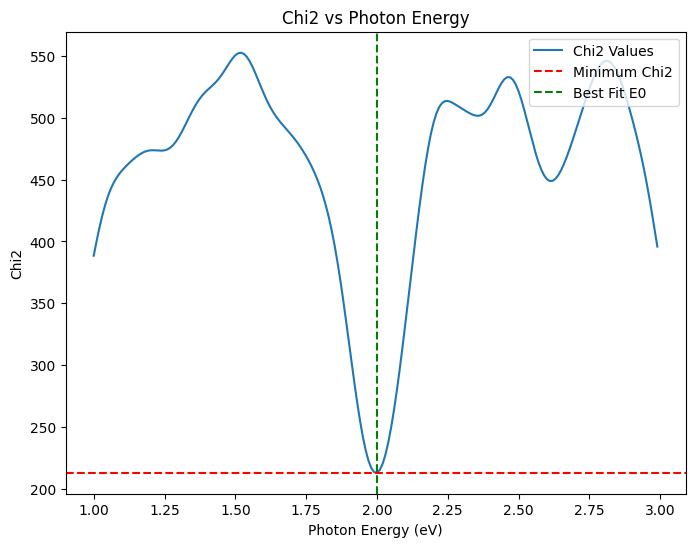

In [219]:
plt.figure(figsize=(8, 6))
plt.plot(Ephotons, chi2s, label='Chi2 Values')
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Chi2')
plt.axhline(y=min_chi2, color='r', linestyle='--', label='Minimum Chi2')
plt.axvline(x=best_E0, color='g', linestyle='--', label='Best Fit E0')
plt.legend(loc='upper right')
plt.title('Chi2 vs Photon Energy')

Find the 1-sigma and 95% error bars for E0, using the function below 

In [220]:
def find_chi2_error_bars(val_arr, bf_val, dchi2s, dchi2_crit=1):
    '''
    Inputs:
    val_arr: array of parmater values
    bf_val: the best fit paramter
    dchi2s: the chi2 at each value - min(chi2)
    dchi2_crit: the delta chi2 value to find your error bars at
    
    Outputs:
    the min and max values of your error bar
    '''
    
    bl = (val_arr < bf_val)
    ind = np.argmin(np.abs(dchi2s[bl] - dchi2_crit))
    val_min_err = val_arr[bl][ind]

    bl = (val_arr > bf_val)
    ind = np.argmin(np.abs(dchi2s[bl] - dchi2_crit))
    val_plus_err = val_arr[bl][ind]
    
    return val_min_err, val_plus_err

In [221]:
dof = 1 # degrees of freedom for 1 parameter fit
desired_sigma = 1
desired_sigma_prob = stats.chi2.cdf(desired_sigma, dof) # find the probability of the chi2 value for 1 sigma

dchi2_crit = stats.chi2.ppf(desired_sigma_prob, dof) # find the critical chi2 value for 1 sigma
find_chi2_error_bars(Ephotons, best_E0, chi2s - min_chi2, dchi2_crit) # 1 sigma error

(np.float64(1.9900000000000009), np.float64(2.0100000000000007))

**The 1-sigma error bars are [1.98,2.0]**

In [222]:
desired_sigma_prob2 = 0.95

dchi2_crit =  stats.chi2.ppf(desired_sigma_prob2, dof)
#print(dchi2_crit)

find_chi2_error_bars(Ephotons, best_E0, chi2s - min_chi2, dchi2_crit) # 2 sigma error

(np.float64(1.9800000000000009), np.float64(2.0100000000000007))

**The 95% (2-sigma) error bars are [1.98,2.01]**

Now let's assume we know 
- the continuum gives an average of 20 counts 
- the amplitude of the line is 25 counts

Let's find what the data can tell us about the center of the line, E0 and the width of the line w

Using brute force, find the best-fit combination of E0 and w

Hint: you may want to construct a 2D array of chi2 values

to find the indexes of the min value of a 2D array use

min_ind0, min_ind1 = np.unravel_index(np.argmin(arr2D), arr2D.shape)

In [223]:
cont_avg = 20
A_line2 = 25

Ephoton_range = np.max(Ephotons) - np.min(Ephotons) #  The max width of the emission line the data can cover
 # the minimum width of the emission line is arbitrarily small (I set it to range/1000)
line_widths = np.linspace(.01,1,200) # Set a array for the line widths to test with small steps

chi2s_grid = np.zeros((len(Ephotons), len(line_widths))) # Create a grid to hold the chi2 values for each E0 and line width
np.sum(chi2s_grid) # check the shape of the grid
#chi2s_grid.shape

for i, E0 in enumerate(Ephotons):
    for j, lw in enumerate(line_widths):
        emiss_line_avg = emiss_line(Ephotons, A_line2, E0, lw)
        counts_expected = continuum_rate + emiss_line_avg
        chi2s_grid[i, j] = calc_chi2(counts_expected, counts, sigmas)

min_ind0, min_ind1 = np.unravel_index(np.argmin(chi2s_grid), chi2s_grid.shape)
np.min(chi2s_grid)

np.float64(219.65072416523773)

In [224]:
print(f"Best fit E0: {Ephotons[min_ind0]:.3f} eV")
print(f"Best fit line width: {line_widths[min_ind1]:.3f} eV")

Best fit E0: 1.990 eV
Best fit line width: 0.035 eV


Plot your best fit curve along with the real data

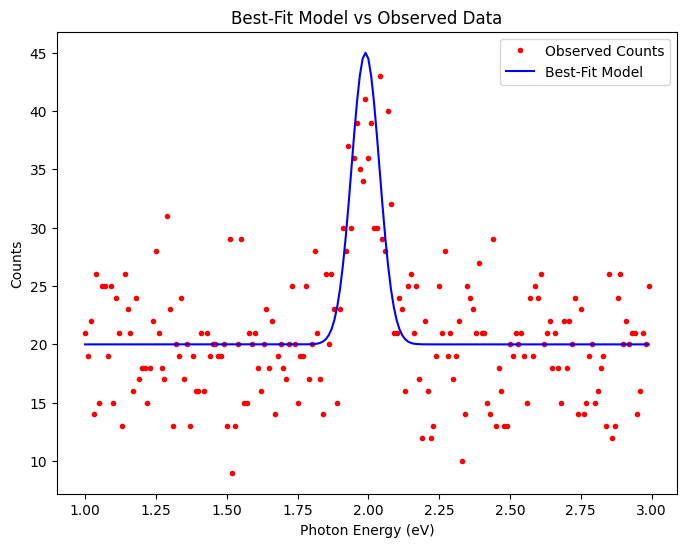

In [225]:
# Calculate the best-fit model using the best-fit E0 and w
best_E0 = Ephotons[min_ind0]
best_w = line_widths[min_ind1]
best_emiss_line = emiss_line(Ephotons, A_line2, best_E0, best_w)
best_counts = continuum_rate + best_emiss_line

# Plot the observed data and the best-fit model
plt.figure(figsize=(8, 6))
plt.plot(Ephotons, counts, '.r', label='Observed Counts')
plt.plot(Ephotons, best_counts, '-b', label='Best-Fit Model')
plt.xlabel('Photon Energy (eV)')
plt.ylabel('Counts')
plt.legend()
plt.title('Best-Fit Model vs Observed Data')
plt.show()

Now make plot a 2D array of Delta chi2 values (chi2 - min(chi2)) with E0 on one axis and w on the other. 

- Add a 50% and 95% error contour to the plot
- Make sure the color scale makes sense to see the important details 

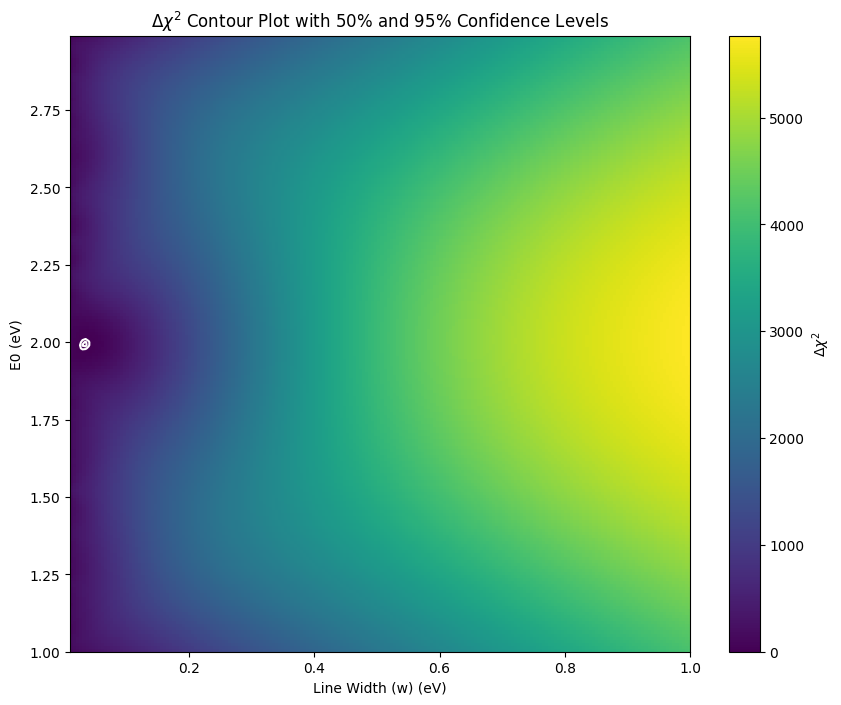

In [226]:
# Calculate the delta chi2 values
delta_chi2 = chi2s_grid - np.min(chi2s_grid)

# Full Range Plot
plt.figure(figsize=(10, 8))
plt.imshow(delta_chi2, extent=[line_widths[0], line_widths[-1], Ephotons[0], Ephotons[-1]], aspect='auto', origin='lower')
plt.colorbar(label=r'$\Delta \chi^2$')

# Degrees of freedom for 2-parameter fit
dof = 2
contour_50 = stats.chi2.ppf(0.5, dof)  # 50% confidence level
contour_95 = stats.chi2.ppf(0.95, dof)  # 95% confidence level
plt.contour(line_widths, Ephotons, delta_chi2, levels=[contour_50, contour_95], colors='white', linewidths=1.5)

# Add labels and title
plt.ylabel('E0 (eV)')
plt.xlabel('Line Width (w) (eV)')
plt.title(r'$\Delta \chi^2$ Contour Plot with 50% and 95% Confidence Levels')
plt.show()


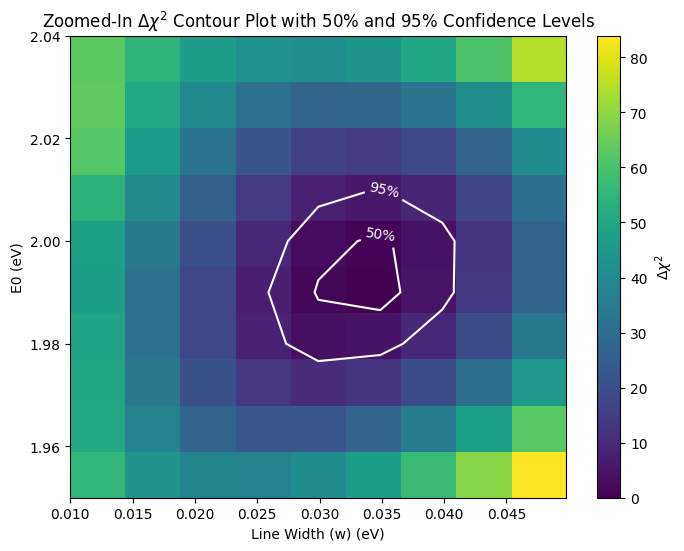

In [229]:
#
# Zoomed-In Plot
zoomed_E0_mask = (Ephotons >= 1.95) & (Ephotons <= 2.05)
zoomed_w_mask = (line_widths >= 0.0) & (line_widths <= 0.05)

# Apply the masks to the delta chi2 grid
zoomed_delta_chi2 = delta_chi2[zoomed_E0_mask, :][:, zoomed_w_mask]
zoomed_E0 = Ephotons[zoomed_E0_mask]
zoomed_w = line_widths[zoomed_w_mask]

plt.figure(figsize=(8, 6))
plt.imshow(zoomed_delta_chi2, extent=[zoomed_w[0], zoomed_w[-1], zoomed_E0[0], zoomed_E0[-1]], aspect='auto', origin='lower')
plt.colorbar(label=r'$\Delta \chi^2$')

# Add 50% and 95% error contours
contours = plt.contour(zoomed_w, zoomed_E0, zoomed_delta_chi2, levels=[contour_50, contour_95], colors='white', linewidths=1.5)

plt.clabel(contours, inline=True, fontsize=10, fmt={contour_50: '50%', contour_95: '95%'})


# Add labels and title
plt.xlabel('Line Width (w) (eV)')
plt.ylabel('E0 (eV)')
plt.title('Zoomed-In $\Delta \chi^2$ Contour Plot with 50% and 95% Confidence Levels')
plt.show()

Now treat w as a nuisance parameter and find the 1-sigma error on E0. 

How does it compare to our error when w was fixed?

In [247]:
# Minimize chi2 over w for each E0
chi2s_minimized_over_w = np.min(chi2s_grid, axis=1)  # Minimize along the w-axis

# Calculate delta chi2 values
delta_chi2_minimized = chi2s_minimized_over_w - np.min(chi2s_minimized_over_w)

# Find the 1-sigma error bars for E0
dof = 1  # Degrees of freedom for 1 parameter (E0)
dchi2_crit = stats.chi2.ppf(stats.chi.cdf(1, dof), dof)  # Critical chi2 value for 1-sigma confidence level
val_min_err, val_plus_err = find_chi2_error_bars(Ephotons, best_E0, delta_chi2_minimized, dchi2_crit)

# Print the results
print(f"Best-fit E0: {best_E0:.3f} eV")
print(f"1-sigma error bars on E0 with w as a nuisance parameter is [{val_min_err:.03f}, {val_plus_err:.03f}] eV,\n \
Best E0 = {best_E0:.3f} eV +- {abs(val_min_err - best_E0)/2:.03f} eV")

Best-fit E0: 1.990 eV
1-sigma error bars on E0 with w as a nuisance parameter is [1.980, 2.000] eV,
 Best E0 = 1.990 eV +- 0.005 eV


After you have completed this tutorial, click the filename at the top left of the page (to the right of the Jupyter logo) and change the name to be in the following format:

FIRSTNAME_LASTNAME_t_XX

where XX is the number for the tutorial (e.g., 05 for tutorial 5, or 11 for tutorial 11). After changing the name, download the notebook file:

File > Download as > Notebook (.ipynb)

and then upload it to the appropriate Dropbox on the Canvas website (you will find the file you want to upload in your Downloads folder when using the Canvas Dropbox page).